# YOLO訓練以及重新定義背景抑制溢出

## 載入圖片與遮罩

標註檔確認用
file_folder 為C:\Users\SSTek\Desktop\total\raw\result\AItest 內容包含(.json .npy .png)

透過filename指定圖片 中文檔案名稱

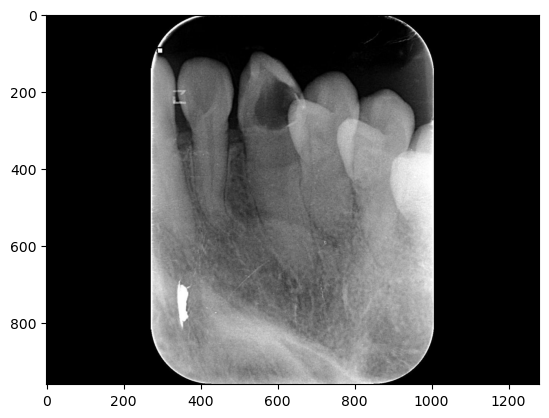

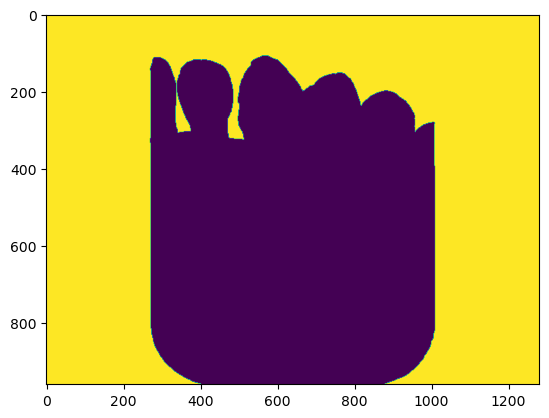

In [1]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
#given the path
file_folder=("../data/pics")
file_name='caries-0.8510638-272-735_1_2022021402'
mask_path=file_folder+'/'+file_name+'.npy'
img_path=file_folder+'/'+file_name+'.png'
meta_label_path=file_folder+'/'+file_name+'.json'
#load file
mask_label=np.load(mask_path)
img=cv2.imread(img_path)
with open(meta_label_path, 'r') as f:
    label_dict=json.load(f)
plt.imshow(img)
plt.show()
for label_name in set(label_dict.values()):
    if label_name=='Background':
        label_value_list=[key for key, value in label_dict.items() if value == label_name]
        mask=np.zeros((img.shape[0],img.shape[1]))
        for label_value in label_value_list:
            mask[mask_label==int(label_value)]=255
            #print(label_value)
        plt.imshow(mask)
    plt.show()

生成驗證集遮罩 作為IOU的檢驗

處理並保存圖片: ../data/pics\processed\processed_caries-0.6741573-260-760_1_2022052768.png
生成並保存反轉遮罩圖片: ../data/pics\processed\background_caries-0.6741573-260-760_1_2022052768.png


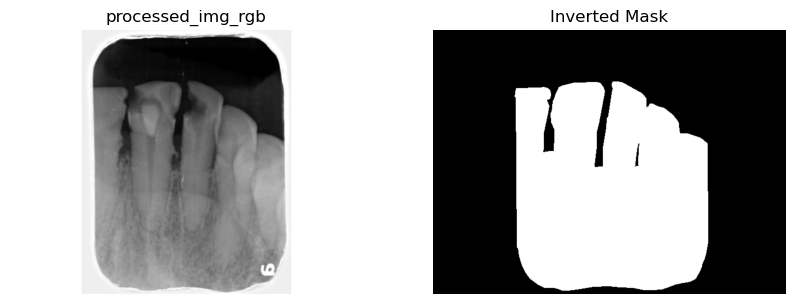

處理並保存圖片: ../data/pics\processed\processed_caries-0.8510638-272-735_1_2022021402.png
生成並保存反轉遮罩圖片: ../data/pics\processed\background_caries-0.8510638-272-735_1_2022021402.png


In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import natsort
import json

def load_images_from_folder(folder_path):
    file_names = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    sorted_file_names = natsort.natsorted(file_names)
    images = []
    for file_name in sorted_file_names:
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
        else:
            print(f"無法讀取圖片: {img_path}")
    return images, sorted_file_names

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if img is None:
        img = cv2.imdecode(np.fromfile(file=file_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    return img

def process_image(img):
    height, width, _ = img.shape
    black_threshold = 50
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([black_threshold, black_threshold, black_threshold])
    mask_black = cv2.inRange(img, lower_black, upper_black)

    left_black_mask = np.all(mask_black == 255, axis=0)
    right_black_mask = np.all(mask_black == 255, axis=0)[::-1]

    left_cut = np.argmax(left_black_mask == False)
    right_cut = np.argmax(right_black_mask == False)

    img[:, :left_cut] = 255
    img[:, width-right_cut:] = 255

    return img, left_cut, right_cut

def create_new_image(img,mask_binary, left_cut, right_cut):
    height, width, _ = img.shape

    new_img = np.zeros((height, width, 3), dtype=np.uint8)

    new_img[mask_binary == 0] = [255, 255, 255]

    new_img[:, :left_cut] = 255
    new_img[:, width-right_cut:] = 255

    return new_img

input_dir = '../data/pics'
processed_dir = os.path.join(input_dir, 'processed')
os.makedirs(processed_dir, exist_ok=True)
#input_dir 之下建立processed資料夾作為輸出


images, file_names = load_images_from_folder(input_dir)

if len(images) == 0:
    raise ValueError("未能從指定的資料夾讀取到圖片。")
displayed = False # 是否顯示圖片
for img, file_name in zip(images, file_names):
    processed_img, left_cut, right_cut = process_image(img)
    output_path = os.path.join(processed_dir, f'processed_{file_name}')
    cv2.imwrite(output_path, processed_img)
    print(f"處理並保存圖片: {output_path}")

    processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
    file_name_without_ext = os.path.splitext(file_name)[0]
    mask_label_path = os.path.join(input_dir, file_name_without_ext + '.npy')
    json_label_path = os.path.join(input_dir, file_name_without_ext + '.json')

    if os.path.exists(mask_label_path) and os.path.exists(json_label_path):
        mask_label = np.load(mask_label_path)
        with open(json_label_path, 'r') as f:
            label_dict = json.load(f)
        # plt.imshow(processed_img_rgb)
        # plt.axis('off')
        # plt.show()
        for label_name in set(label_dict.values()):
            if label_name == 'Background':
                label_value_list = [key for key, value in label_dict.items() if value == label_name]
                mask = np.zeros((img.shape[0], img.shape[1]))
                for label_value in label_value_list:
                    mask[mask_label == int(label_value)] = 255
                _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
                inv_mask = np.zeros_like(img)
                inv_mask[mask_binary == 0] = [255, 255, 255]  # 黑色部分變為白色
                inv_mask[mask_binary == 255] = [0, 0, 0]  # 白色部分變為黑色
                # 保存 mask 遮罩
                # mask_inverted_path = os.path.join(output_folder, f'mask_{file_name}')
                # cv2.imwrite(mask_inverted_path, mask_binary)
                # print(f"生成並保存反轉遮罩圖片: {mask_inverted_path}")
                # 保存 inv_mask 遮罩
                mask_inverted_path = os.path.join(processed_dir, f'background_{file_name}')
                cv2.imwrite(mask_inverted_path, inv_mask)
                print(f"生成並保存反轉遮罩圖片: {mask_inverted_path}")
                # # Debug: Check if mask_inverted contains white pixels
                # if np.any(mask_binary == 0):
                #     print("mask_inverted 含有白色區域")
                #     # Find coordinates of white pixels
                #     white_coords = np.column_stack(np.where(mask_binary == 0))
                #     print(f"白色區域的坐標範圍: {white_coords[:10]}")  # print first 10 coordinates
                #     print(f"白色區域的數量: {white_coords.shape[0]}")
                # else:
                #     print("mask_inverted 沒有白色區域")
                #     unique_values = np.unique(mask_binary)
                #     print(f"mask_inverted 包含的其他像素值: {unique_values}")
                if not displayed:  # 只顯示第一張圖
                    plt.figure(figsize=(10, 5))  # 設定圖片大小
                    plt.subplot(1, 2, 1)  #1
                    plt.imshow(processed_img_rgb, cmap='gray')
                    plt.title('processed_img_rgb')
                    plt.axis('off')
                    plt.subplot(1, 2, 2)  #2
                    plt.imshow(inv_mask, cmap='gray')
                    plt.title('Inverted Mask')
                    plt.axis('off')
                    plt.show()
                    displayed = True  # 顯示過一次後設置旗標為True
        plt.show()
        new_image = create_new_image(img,mask_binary, left_cut, right_cut)


## 載入yolo模型

導入模型 Yolov8n.pt檔

dentistry_yolov8n_20240807_all.pt

In [3]:
from ultralytics import YOLO
# 加載YOLO模型
model = YOLO('../models/dentistry_yolov8n_20240807_all.pt')

In [4]:
import cv2
import numpy as np
import re, os
import natsort
import matplotlib.pyplot as plt

透過YOLO模型對x光圖片做遮罩

由於顏色是疊加的 所以採用根據平均亮度對顏色做抑制 避免過暴

算平均亮度在這部分的 function reduce_brightness_by_half

In [5]:
# 指定亮度記錄文件
log_dir = os.path.join(os.path.dirname(input_dir),"log")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
log_file = os.path.join(log_dir, "log.txt")

In [6]:
# 定義標題和描述
title = "牙科模型分割示範"
description = "輸入一張圖片並獲取分割結果"

def find_center_mask(mask_binary):
    """
    找到二值掩膜的質心（中心點）。
    """
    moments = cv2.moments(mask_binary)
    if moments['m00'] != 0:  # 確保掩膜不全為零
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = None, None  # 如果掩膜全為零
    return (cx, cy)

def reduce_brightness_by_half(image, color):
    """
    根據圖像的平均亮度動態調整RGB顏色的亮度。
    
    :param image: 用於計算平均亮度的圖像（灰度圖或RGB圖像）
    :param color: 要調整的RGB顏色，例如 [255, 240, 0]
    :return: 根據平均亮度調整後的RGB顏色，並返回平均亮度和scale_factor
    """
    # 計算圖片的平均亮度
    mean_brightness = np.mean(image)
    

    # 根據平均亮度動態調整顏色的亮度
    if mean_brightness <= 120:
        scale_factor = 0.8  # 當亮度較低時，減少顏色亮度 
    if 120< mean_brightness <= 150:
        scale_factor = 0.6  # 當亮度較低時，減少顏色亮度
    if mean_brightness > 150:
        scale_factor = 0.4  # 當亮度較高時，進一步減少顏色亮度
    else:
        scale_factor = 1.0  # 在平均亮度時，保持原有亮度

    # 調整顏色亮度
    adjusted_color = np.clip(np.array(color) * scale_factor, 0, 255).astype(np.uint8)
    return adjusted_color, mean_brightness, scale_factor

def fill_missing_with_dentin(image, dentin_color=[29, 41, 113]):
    """
    將未填充的區域使用dentin顏色填充。
    """
    # 找出指定顏色範圍內的未填充區域
    mask = cv2.inRange(image, np.array([50, 50, 50]), np.array([0, 0, 200]))
    
    # 找到這些區域的輪廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:    
        # 建立一個用於填充的掩膜
        fill_mask = np.zeros_like(image)
        cv2.drawContours(fill_mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        
        # 將填充區域設為dentin_color
        image[fill_mask == 255] = dentin_color
    
    return image

def colorize_mask(image, file_path, log_file):
    """
    使用YOLO模型對圖像進行分割，並調整亮度和填充未填滿的區域。
    
    :param image: 輸入的圖像
    :param file_path: 圖像的文件路徑
    :param log_file: 記錄亮度和scale_factor的文件
    :return: 處理後的圖像
    """
    # 取得檔案名稱，並移除 "processed_"
    file_name = os.path.basename(file_path)
    if file_name.startswith("processed_"):
        file_name = file_name[len("processed_"):]
    if file_name.endswith(".png"):
        file_name = file_name[:-len(".png")]
    # 定義調整後的顏色列表
    plot_image = image.copy()
    color_list = [ #用於labels
        [255, 240, 0],  # Alveolar_bone
        [0, 127, 65],   # Caries
        [255, 0, 0],    # Crown
        [29, 41, 113],  # Dentin
        [135, 21, 122], # Enamel
        [242, 148, 0],  # Implant
        [234, 84, 4],   # Mandibular_alveolar_nerve
        [178, 208, 0],  # Maxillary_sinus
        [148, 97, 52],  # Molar_bone
        [121, 121, 121],# Post_and_Core
        [27, 149, 212], # Pulp
        [255, 171, 206],# Restoration
        [216, 28, 110]  # Root_canal_filling
    ]

    # 根據圖像亮度動態調整顏色
    adjusted_color_list = []
    mean_brightness_total = 0
    for color in color_list:
        adjusted_color, mean_brightness, scale_factor = reduce_brightness_by_half(image, color)
        adjusted_color_list.append(adjusted_color)
        mean_brightness_total += mean_brightness
    print(f"圖片的平均亮度: {mean_brightness}")
    color_dict = {i: color for i, color in enumerate(adjusted_color_list)}

    # 記錄亮度和scale_factor
    file_name = os.path.basename(file_path)
    mean_brightness_avg = mean_brightness_total / len(color_list)
    with open(log_file, 'a') as f:
        f.write(f"{file_name}\n")
        f.write(f"平均亮度: {mean_brightness_avg}\n")
        f.write(f"scale_factor: {scale_factor}\n\n")

    # 將圖像轉換為RGB格式，以適應YOLO模型
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image)

    class_names = model.names
    kernel = np.ones((5, 5), np.uint8)  # 用於膨脹操作的內核

    for result in results:
        boxes = result.boxes
        masks = result.masks

        if masks is not None:
            for (mask, box) in zip(masks.data, boxes):
                class_id = int(box.cls)
                class_name = class_names[class_id]

                mask_np = mask.cpu().numpy()
                mask_np = cv2.resize(mask_np, (image.shape[1], image.shape[0]))
                mask_binary = (mask_np > 0.5).astype(np.uint8) * 255

                if np.sum(mask_binary) == 0:
                    continue

                # 添加膨脹操作以擴展遮罩
                mask_binary = cv2.dilate(mask_binary, kernel, iterations=1)

                # 使用洪水填充填補孔洞
                flood_fill_mask = mask_binary.copy()
                h, w = flood_fill_mask.shape[:2]
                mask_floodfill = np.zeros((h + 2, w + 2), np.uint8)
                cv2.floodFill(flood_fill_mask, mask_floodfill, (0, 0), 255)
                flood_fill_mask_inv = cv2.bitwise_not(flood_fill_mask)
                mask_filled = mask_binary | flood_fill_mask_inv

                mask_colored = np.zeros((mask_filled.shape[0], mask_filled.shape[1], 3), dtype=np.uint8)
                if class_name != 'Background':
                    mask_colored[mask_filled == 255] = color_dict[class_id]
                    plot_image = cv2.addWeighted(plot_image, 1, mask_colored, 0.8, 0)

    # 使用dentin顏色填充未填滿的區域
    dentin_color = color_dict[3]  # Dentin的顏色
    plot_image = fill_missing_with_dentin(plot_image, dentin_color)

    number = re.search(r'\d+', file_name).group()
    output_dir = os.path.join(os.path.dirname(file_path), "AI")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # 保存處理後的圖片
    output_path = os.path.join(output_dir, f"AI_{file_name}")
    plot_image_bgr = cv2.cvtColor(plot_image, cv2.COLOR_RGB2BGR)  # 將RGB轉換回BGR以便使用OpenCV保存
    # 檢查目錄是否存在，如果不存在則創建該目錄
    
    cv2.imwrite(output_path, plot_image_bgr)
    print(f"圖片已保存至 {output_path}")

    return plot_image

def process_all_images_in_folder(folder_path, log_file):
    """
    讀取資料夾中的所有 PNG 圖片，並依自然排序處理每張圖片。
    
    :param folder_path: 包含 PNG 圖片的資料夾路徑
    :param log_file: 記錄亮度和scale_factor的文件
    """
    # 獲取資料夾中所有 PNG 檔案，並按自然順序排序
    image_files = natsort.natsorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    # 逐一處理每張圖片
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        print(f"正在處理: {file_path}")
        img = cv2.imread(file_path)
        colorize_mask(img, file_path, log_file)


# 處理指定資料夾中的所有圖片
process_all_images_in_folder(input_dir, log_file)



正在處理: ../data/pics\caries-0.6741573-260-760_1_2022052768.png
圖片的平均亮度: 73.05750813802084

0: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 83.7ms
Speed: 4.0ms preprocess, 83.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)
圖片已保存至 ../data/pics\AI\AI_caries-0.6741573-260-760_1_2022052768.png
正在處理: ../data/pics\caries-0.8510638-272-735_1_2022021402.png
圖片的平均亮度: 63.38848225911458

0: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Background, 60.9ms
Speed: 2.0ms preprocess, 60.9ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)
圖片已保存至 ../data/pics\AI\AI_caries-0.8510638-272-735_1_2022021402.png


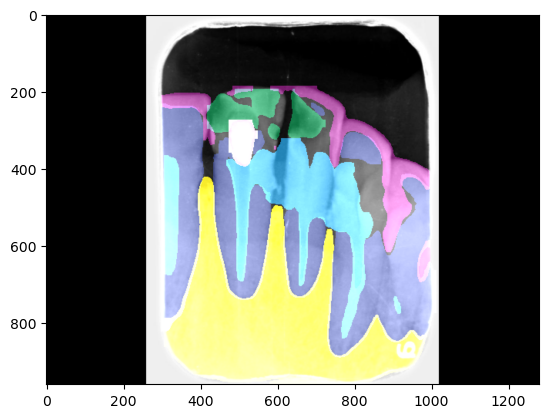

In [15]:
def show_img_by_path(img_path):
    test_img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)
    plt.show()
show_img_by_path('../data/pics/AI/AI_caries-0.6741573-260-760_1_2022052768.png')

## yolo模型後處理

初步定義背景遮罩 進入背景遮罩的前處理且需排除異常噪點

In [14]:
import cv2
import numpy as np
import os
import natsort

image_dir='../data/pics'
# 輸入
inference_image_dir = os.path.join(image_dir, "AI")
# 推論AI結果的輸入資料夾
#output_dir = os.path.join(image_dir, "output")
# 輸出資料夾
mask_dir = os.path.join(image_dir, "test")
# 遮罩（黑白圖）
os.makedirs(mask_dir,exist_ok=True)

# 取得並排序原始圖像和推理圖像的 PNG 文件名
image_files = natsort.natsorted([f for f in os.listdir(image_dir) if f.endswith('.png') and os.path.isfile(os.path.join(image_dir, f))])
inference_files = natsort.natsorted([f for f in os.listdir(inference_image_dir) if f.endswith('.png') and os.path.isfile(os.path.join(inference_image_dir, f))])

# 確保原始圖像和推理圖像的數量一致
if len(image_files) != len(inference_files):
    print("原始圖像文件數量和推理圖像文件數量不匹配。")
    exit()

# 迴圈處理所有圖像文件
for img_idx, image_file in enumerate(image_files):
    input_dir = os.path.join(image_dir, image_file)
    inference_image_path = os.path.join(inference_image_dir, inference_files[img_idx])
    
    # 讀取原始圖像，確保可以處理中文檔名
    img = cv2.imdecode(np.fromfile(input_dir, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"無法讀取圖片: {input_dir}")
        continue
    
    # 轉換為灰階圖像
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 定義HSV範圍
    hsv_lower_bound = np.array([0, 0, 31])
    hsv_upper_bound = np.array([0, 0, 154])

    # 轉換為HSV圖像
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 計算在特定HSV範圍內的像素數量
    HSV_mask = cv2.inRange(hsv_image, hsv_lower_bound, hsv_upper_bound)
    pixels_in_range = cv2.countNonZero(HSV_mask)

    # 初始化 replaced_mask
    replaced_mask = np.zeros_like(gray_image)
    if 880000 > pixels_in_range >= 620000:
        print(f"Stage1: {input_dir}")
        threshold_value_white = 20
    elif pixels_in_range >= 880000:
        print(f"Stage2: {input_dir}")
        threshold_value_white = 11
    else:
        print(f"Stage3: {input_dir}")
        threshold_value_white = 220

    # 處理高於閾值的像素
    image_replaced = np.where(img > threshold_value_white, 128, img)
    replaced_mask = ((img > threshold_value_white)).astype(np.uint8)
    replaced_mask = replaced_mask * 255
    gray_image = cv2.cvtColor(image_replaced, cv2.COLOR_BGR2GRAY)

    # 使用 Otsu's 方法進行二值化
    _, binarized_image_otsu = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 創建黑色遮罩
    black_mask = np.zeros_like(img)
    black_mask[binarized_image_otsu == 0] = [0, 0, 0]  # 黑色區域
    black_mask[binarized_image_otsu == 255] = [255, 255, 255]  # 白色區域
    black_mask[replaced_mask == 255] = [255]  # 使用白色表示被替換的區域

    # 閉運算內核
    kernel = np.ones((5, 5), np.uint8)  
    # 閉運算
    closing = cv2.morphologyEx(black_mask, cv2.MORPH_CLOSE, kernel)

    # 找到遮罩中的所有輪廓
    contours, _ = cv2.findContours(cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 遍歷所有輪廓，根據面積和顏色進行填充
    for contour in contours:
        area = cv2.contourArea(contour)
        mask = np.zeros_like(gray_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # 計算輪廓內部的平均顏色
        mean_val = cv2.mean(gray_image, mask=mask)[0]
        
        if area < 900 and mean_val > 128:  # 白色區域（平均值接近255）
            print(f"填充面積小於900的白色區域為黑色，面積為: {area}")
            cv2.drawContours(closing, [contour], -1, (0, 0, 0), thickness=cv2.FILLED)  # 將面積小於900的白色區域填滿黑色
        elif area < 600 and mean_val <= 128:  # 黑色區域（平均值接近0）
            print(f"填充面積小於600的黑色區域為白色，面積為: {area}")
            cv2.drawContours(closing, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)  # 將面積小於600的黑色區域填滿白色
    
    # 獲取文件名稱（去除.png後綴）
    base_filename = os.path.splitext(image_file)[0]

    # 保存遮罩圖像以供檢查
    mask_output_image_path = os.path.join(mask_dir, f"{base_filename}_mask.png")
    cv2.imencode('.png', closing)[1].tofile(mask_output_image_path)
    print(f"保存mask圖像到: {mask_output_image_path}")

    # 讀取對應的推理圖像
    inference_image = cv2.imdecode(np.fromfile(inference_image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if inference_image is None:
        print(f"無法讀取推理圖片: {inference_image_path}")
        continue

    # 將 closing 轉換為灰度圖像
    closing_gray = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)
    # 將黑色遮罩應用到推理圖像上
    inference_image[closing_gray == 0] = [0]  # 只覆蓋黑色部分

    # 保存處理後的圖片
    #output_image_path = os.path.join(output_dir, f"{base_filename}.png")
    #cv2.imencode('.png', inference_image)[1].tofile(output_image_path)
    #print(f"保存處理後的圖片到: {output_image_path}")


Stage3: ../data/pics\caries-0.6741573-260-760_1_2022052768.png
保存mask圖像到: ../data/pics\test\caries-0.6741573-260-760_1_2022052768_mask.png
Stage3: ../data/pics\caries-0.8510638-272-735_1_2022021402.png
保存mask圖像到: ../data/pics\test\caries-0.8510638-272-735_1_2022021402_mask.png


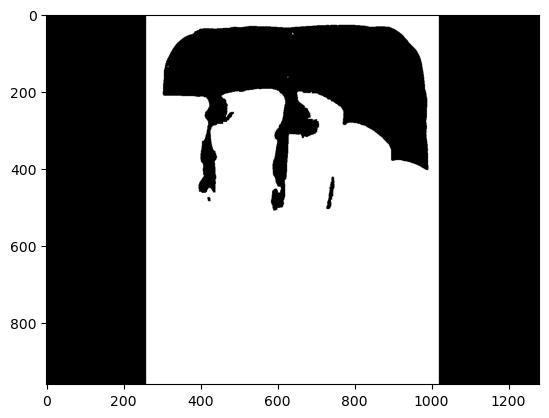

In [16]:
show_img_by_path('../data/pics/test/caries-0.6741573-260-760_1_2022052768_mask.png')

再進行第二次的處理，進行開閉操作，補齊不完整的部分

In [18]:
import cv2
import numpy as np
import os
import natsort

# 讀取圖像
inference_image_dir = os.path.join(image_dir, "test")
# 讀取AI辯識後的圖 做為牙齦補強
gum_dir = os.path.join(image_dir, "AI")
mask_dir = os.path.join(image_dir, "Mask")

# 確保輸出目錄存在
os.makedirs(mask_dir,exist_ok=True)

# 獲取並排序原始圖像和推理圖像的文件名
inf_files = natsort.natsorted([f for f in os.listdir(inference_image_dir) if f.endswith(".png")])
gum_files = natsort.natsorted([f for f in os.listdir(gum_dir) if f.endswith(".png")])

# 確保兩個文件列表長度相同
if len(inf_files) != len(gum_files):
    print("Mask目錄和AI目錄中的文件數量不匹配")
else:
    for img_idx, file in enumerate(inf_files):
        # 讀取推理圖像
        input_dir = os.path.join(inference_image_dir, file)
        image = cv2.imread(input_dir, cv2.IMREAD_GRAYSCALE)  # 灰度讀取圖像

        # 讀取gum_dir中的對應圖像
        gum_image_path = os.path.join(gum_dir, gum_files[img_idx])
        gum_image = cv2.imread(gum_image_path)

        # 檢查圖像是否加載成功
        if gum_image is None:
            print(f"未能加載圖像: {gum_image_path}")
            continue

        # 將gum_image轉為HSV空間
        hsv_gum_image = cv2.cvtColor(gum_image, cv2.COLOR_BGR2HSV)

        # 定義HSV範圍並創建遮罩
        lower_hsv = np.array([28, 0, 200])
        upper_hsv = np.array([40, 255, 255])
        gum_mask = cv2.inRange(hsv_gum_image, lower_hsv, upper_hsv)

        # 找到gum_mask中的輪廓
        gum_contours, _ = cv2.findContours(gum_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 遍歷gum_mask中的輪廓
        for gum_contour in gum_contours:
            gum_area = cv2.contourArea(gum_contour)
            if gum_area < 1000:  # 如果面積小於1000，進行填充
                cv2.drawContours(gum_mask, [gum_contour], -1, 255, thickness=cv2.FILLED)

        # 將 gum_mask 填充為白色
        gum_mask_colored = cv2.cvtColor(gum_mask, cv2.COLOR_GRAY2BGR)
        gum_mask_colored[gum_mask > 0] = (255, 255, 255)

        # 保存處理過的gum_mask圖像
        # gum_output_path = os.path.join(mask_output_dir, f"{os.path.splitext(file)[0]}_gum.png")
        # cv2.imwrite(gum_output_path, gum_mask_colored)

        # 將原始圖像轉換為彩色圖像以顯示輪廓
        contour_display_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # 閉運算內核
        kernel = np.ones((5, 5), np.uint8)
        opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # 高斯模糊
        gaussian_blur = cv2.GaussianBlur(closing, (5, 5), 0)

        # 使用Canny邊緣檢測
        canny_edges = cv2.Canny(gaussian_blur, 100, 200)  # 100和200是低閥值和高閥值

        # 找到Canny邊緣檢測的輪廓
        contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 遍歷所有輪廓，根據面積和顏色進行填充
        for contour in contours:
            area = cv2.contourArea(contour)
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

            # 計算輪廓內部的平均顏色
            mean_val = cv2.mean(image, mask=mask)[0]

            if area < 1000 and mean_val > 128:  # 白色（平均值接近255）
                print(f"填充面積小於1000的白色區域為黑色，面積為: {area}")
                cv2.drawContours(contour_display_image, [contour], -1, (0, 0, 0), thickness=cv2.FILLED)  # 將面積小於1000的白色區域填滿黑色
            elif area < 600 and mean_val <= 128:  # 黑色（平均值接近0）
                print(f"填充面積小於600的黑色區域為白色，面積為: {area}")
                cv2.drawContours(contour_display_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)  # 將面積小於600的黑色區域填滿白色
            else:
                # 在輪廓上繪製並標記面積
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])

        # 最後將gum_mask覆蓋到contour_display_image上
        contour_display_image[gum_mask > 0] = (255, 255, 255)

        # 二次處理：再次進行Canny邊緣檢測和形態學處理以去除小點和填補孔洞
        final_image_gray = cv2.cvtColor(contour_display_image, cv2.COLOR_BGR2GRAY)
        final_canny_edges = cv2.Canny(final_image_gray, 50, 300)
        kernel = np.ones((8, 8), np.uint8)
        final_closing = cv2.morphologyEx(final_canny_edges, cv2.MORPH_CLOSE, kernel)

        # 將Canny邊緣檢測結果轉換為彩色圖像以顯示輪廓
        final_image_colored = cv2.cvtColor(final_closing, cv2.COLOR_GRAY2BGR)
        contour_display_image[final_closing > 0] = (0, 0, 0)

        # 保存最終結果
        base_filename = os.path.splitext(file)[0]
        contour_marked_output_path = os.path.join(mask_dir, f"{base_filename}.png")
        cv2.imwrite(contour_marked_output_path, contour_display_image)


填充面積小於600的黑色區域為白色，面積為: 64.5
填充面積小於600的黑色區域為白色，面積為: 7.0
填充面積小於600的黑色區域為白色，面積為: 7.0
填充面積小於600的黑色區域為白色，面積為: 14.5
填充面積小於600的黑色區域為白色，面積為: 403.5
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於600的黑色區域為白色，面積為: 0.0
填充面積小於600的黑色區域為白色，面積為: 25.0
填充面積小於600的黑色區域為白色，面積為: 7.0
填充面積小於600的黑色區域為白色，面積為: 18.0
填充面積小於600的黑色區域為白色，面積為: 8.0
填充面積小於600的黑色區域為白色，面積為: 2.0
填充面積小於600的黑色區域為白色，面積為: 2.0
填充面積小於600的黑色區域為白色，面積為: 4.0
填充面積小於1000的白色區域為黑色，面積為: 58.0
填充面積小於1000的白色區域為黑色，面積為: 39.5
填充面積小於600的黑色區域為白色，面積為: 8.0
填充面積小於600的黑色區域為白色，面積為: 23.5
填充面積小於600的黑色區域為白色，面積為: 6.5
填充面積小於600的黑色區域為白色，面積為: 6.0
填充面積小於600的黑色區域為白色，面積為: 6.0
填充面積小於600的黑色區域為白色，面積為: 15.5
填充面積小於600的黑色區域為白色，面積為: 6.0
填充面積小於600的黑色區域為白色，面積為: 8.0
填充面積小於600的黑色區域為白色，面積為: 1.0
填充面積小於600的黑色區域為白色，面積為: 8.5
填充面積小於600的黑色區域為白色，面積為: 1.0
填充面積小於600的黑色區域為白色，面積為: 51.0
填充面積小於600的黑色區域為白色，面積為: 6.0
填充面積小於600的黑色區域為白色，面積為: 172.5
填充面積小於600的黑色區域為白色，面積為: 78.5
填充面積小於1000的白色區域為黑色，面積為: 15.0
填充面積小於600的黑色區域為白色，面積為: 176.0
填充面積小於600的黑色區域為白色，面積為: 181.5
填充面積小於600的黑色區域為白色，面積為: 8.0
填充面積小於600的黑色區域為白色，面積為: 41.0
填充面積

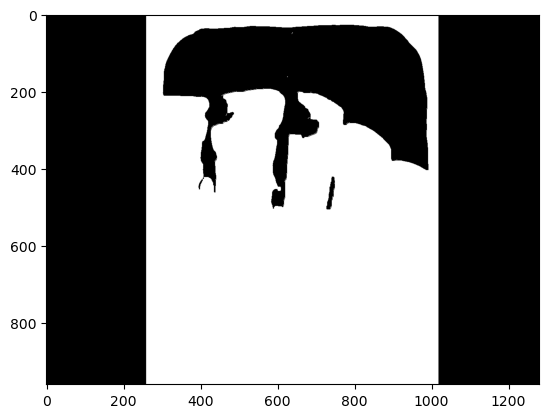

In [19]:
show_img_by_path('../data/pics/Mask/caries-0.6741573-260-760_1_2022052768_mask.png')

將處理好的背景覆蓋在圖片上

In [20]:
import cv2
import numpy as np
import os
import natsort


# 輸入
inference_image_dir = os.path.join(image_dir, "AI")
# 輸入資料夾
mask_dir = os.path.join(image_dir, "Mask")
# 推論AI結果的輸入資料夾
processed_dir = os.path.join(image_dir, "output")
# 遮罩（黑白圖）
os.makedirs(processed_dir,exist_ok=True)

# 取得並排序原始圖像和推理圖像的 PNG 文件名
inference_files = natsort.natsorted([f for f in os.listdir(inference_image_dir) if f.endswith('.png') and os.path.isfile(os.path.join(inference_image_dir, f))])
mask_files = natsort.natsorted([f for f in os.listdir(mask_dir) if f.endswith('.png') and os.path.isfile(os.path.join(mask_dir, f))])

# 確保原始圖像和推理圖像的數量一致
if len(mask_files) != len(inference_files):
    print("原始圖像文件數量和推理圖像文件數量不匹配。")
    exit()

# 迴圈處理所有圖像文件
for img_idx, mask_file in enumerate(mask_files):
    mask_image_path = os.path.join(mask_dir, mask_file)
    inference_image_path = os.path.join(inference_image_dir, inference_files[img_idx])
    
    # 讀取遮罩圖像，確保可以處理中文檔名
    mask_img = cv2.imdecode(np.fromfile(mask_image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if mask_img is None:
        print(f"無法讀取遮罩圖片: {mask_image_path}")
        continue
    
    # 讀取對應的推理圖像
    inference_image = cv2.imdecode(np.fromfile(inference_image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if inference_image is None:
        print(f"無法讀取推理圖片: {inference_image_path}")
        continue
    
    # 將遮罩圖像轉換為灰度圖像
    gray_mask = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)

    # 將黑色部分（像素值為0）定義為遮罩，覆蓋到推理圖像上
    inference_image[gray_mask == 0] = 0  # 只覆蓋黑色部分

    # 獲取文件名稱（去除.png後綴）
    base_filename = os.path.splitext(mask_file)[0]

    # 保存處理後的圖片
    output_image_path = os.path.join(processed_dir, f"{base_filename}.png")
    cv2.imencode('.png', inference_image)[1].tofile(output_image_path)
    print(f"保存處理後的圖片到: {output_image_path}")


保存處理後的圖片到: ../data/pics\output\caries-0.6741573-260-760_1_2022052768_mask.png
保存處理後的圖片到: ../data/pics\output\caries-0.8510638-272-735_1_2022021402_mask.png


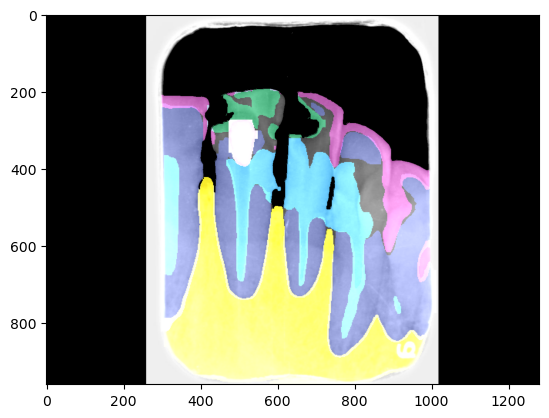

In [22]:
show_img_by_path('../data/pics/output/caries-0.6741573-260-760_1_2022052768_mask.png')

# IOU計算

Average IoU: 0.8391077768818326

In [28]:
import os
import numpy as np
from PIL import Image
from natsort import natsorted

def calculate_iou(mask1, mask2):
    # IOU計算
    mask1 = np.array(mask1).astype(bool)
    mask2 = np.array(mask2).astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def process_folders(training_folder, validation_folder):
    # 自然排序讀取文件
    training_files = natsorted(os.listdir(training_folder))
    validation_files = natsorted(os.listdir(validation_folder))
    ious = []
    for train_file, val_file in zip(training_files, validation_files):
        train_path = os.path.join(training_folder, train_file)
        val_path = os.path.join(validation_folder, val_file)
        try:
            if train_path.endswith('.png') and val_path.endswith('.png'):
                mask_train = Image.open(train_path).convert('L')
                mask_val = Image.open(val_path).convert('L')
                
                iou = calculate_iou(mask_train, mask_val)
                ious.append((train_file, val_file, iou))
        except:
            pass
    return ious

# 訓練集與驗證集文件夾路徑
training_folder = mask_dir
validation_folder = processed_dir

# 計算所有文件的IoU
ious = process_folders(training_folder, validation_folder)

# 輸出每個文件的IoU
total_iou = 0
for train_file, val_file, iou in ious:
    print(f"Valid : {val_file}")  # 驗證集標籤
    print(f"Train : {train_file}")  # 訓練集遮罩
    print(f"IoU: {iou}")
    print("\n")
    total_iou += iou

# 計算並輸出平均IoU
average_iou = total_iou / len(ious) if ious else 0
print(f"Average IoU: {average_iou}")


Valid : background_caries-0.6741573-260-760_1_2022052768.png
Train : caries-0.6741573-260-760_1_2022052768_mask.png
IoU: 0.7679716915052032


Valid : background_caries-0.8480566-272-736_1_2022022381.png
Train : caries-0.8480566-272-736_1_2022022381_mask.png
IoU: 0.9651432693832791


Valid : background_caries-0.8510638-271-738_0_2022022321.png
Train : caries-0.8510638-271-738_0_2022022321_mask.png
IoU: 0.8783912744541837


Valid : background_caries-0.8510638-271-738_1_2021102004.png
Train : caries-0.8510638-271-738_1_2021102004_mask.png
IoU: 0.9391208399583311


Valid : background_caries-0.8510638-271-738_1_2021112206.png
Train : caries-0.8510638-271-738_1_2021112206_mask.png
IoU: 0.9326626083305845


Valid : background_caries-0.8510638-272-735_1_2022021402.png
Train : caries-0.8510638-272-735_1_2022021402_mask.png
IoU: 0.9577896732463477


Valid : background_caries-0.8510638-272-735_1_2022022304.png
Train : caries-0.8510638-272-735_1_2022022304_mask.png
IoU: 0.9577896732463477


Valid 

# 針對IOU數值偏差的處理方法 
部分圖片的局部亮度偏高,導致明亮對比容易被拉偏,會導致偏暗的牙質被視為背景 此處為嘗試的解決方法

C:\Users\SSTek\AppData\Local\Temp\ipykernel_25760\88519549.py:10: RuntimeWarning: divide by zero encountered in scalar power
  table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
C:\Users\SSTek\AppData\Local\Temp\ipykernel_25760\88519549.py:10: RuntimeWarning: invalid value encountered in cast
  table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")


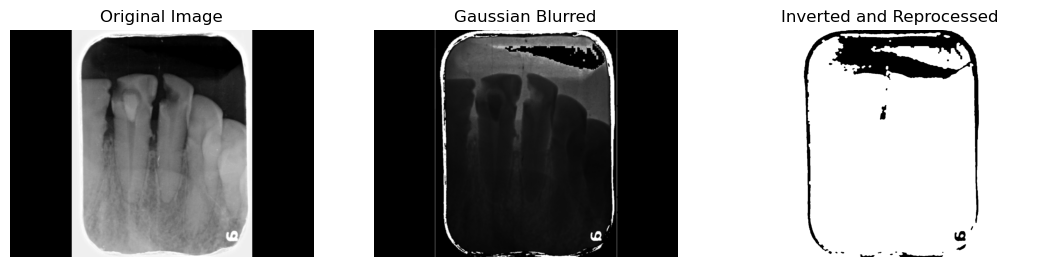

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def adjust_gamma(image, gamma=1.0):
    """ 調整圖像gamma值 """
    """ 注意[不要為正數] """
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def main():
    # 圖像路徑
    #image_dir = r"C:\Users\SSTek\repo\Dentistry-Inference-PeriodontalDisease\inference"
    image_file = "caries-0.6741573-260-760_1_2022052768.png"
    image_path = os.path.join(image_dir, image_file)
    
    # gamma調整 為負提高暗處對比
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gamma_adjusted_image = adjust_gamma(image, gamma=-10)  # gamma值為-10 提高圖灰階亮度
    
    # 高斯模糊
    blurred_image = cv2.GaussianBlur(gamma_adjusted_image, (5, 5), 0)  # 高斯模糊，核大小5x5
    
    # 使用 Otsu 二值化
    _, otsu_thresh = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 形態學
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    eroded = cv2.erode(otsu_thresh, kernel, iterations=1)  # 侵蝕
    dilated = cv2.dilate(eroded, kernel, iterations=2)     # 膨脹
    
    # 圖像反轉
    inverted = cv2.bitwise_not(dilated)
    
    # 再次侵蝕和膨脹
    eroded_again = cv2.erode(inverted, kernel, iterations=1)  # 侵蝕
    dilated_again = cv2.dilate(eroded_again, kernel, iterations=2)  # 膨脹
    
    # 提取輪廓
    contours, _ = cv2.findContours(dilated_again, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 篩除面積小於5000的輪廓
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= 0]
    
    # 建立空白圖像以顯示篩選後的輪廓
    contour_image = np.zeros_like(dilated_again)
    cv2.drawContours(contour_image, filtered_contours, -1, (255), thickness=cv2.FILLED)
    
    # 顯示處理結果
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(blurred_image, cmap='gray')
    plt.title('Gaussian Blurred')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(dilated_again, cmap='gray')
    plt.title('Inverted and Reprocessed')
    plt.axis('off')

    # plt.subplot(1, 4, 4)
    # plt.imshow(contour_image, cmap='gray')
    # plt.title('Filtered Contours')
    # plt.axis('off')

    plt.show()
    
    # 保存處理後的圖像
    output_dir = input_dir+'/try'
    os.makedirs(output_dir,exist_ok=True)
    
    cv2.imwrite(os.path.join(output_dir, 'dilated_again.png'), dilated_again)

if __name__ == '__main__':
    main()


透過明亮度調整可使圖片成像更加的清晰 但還需要optuna或閥質的調整

C:\Users\SSTek\AppData\Local\Temp\ipykernel_25760\1655984107.py:9: RuntimeWarning: divide by zero encountered in scalar power
  table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
C:\Users\SSTek\AppData\Local\Temp\ipykernel_25760\1655984107.py:9: RuntimeWarning: invalid value encountered in cast
  table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")


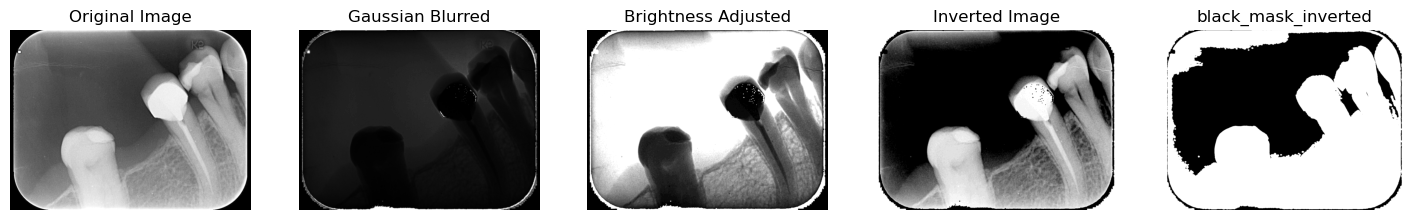

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def adjust_gamma(image, gamma=1.0):
    """ 調整圖像gamma值 """
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def adjust_brightness(image, beta=50):
    """ 調整圖像亮度 """
    return cv2.convertScaleAbs(image, alpha=1, beta=beta)

def main():
    # 圖像路徑
    image_dir = r"C:\Users\SSTek\repo\Dentistry-Inference-PeriodontalDisease\inference"
    image_file = "caries-1.100917-19-1241_1_2021102709.png"
    image_path = os.path.join(image_dir, image_file)
    
    # gamma調整 提高暗處對比
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gamma_adjusted_image = adjust_gamma(image, gamma=-10)  # gamma值為-10，強化灰階對比度
    
    # 高斯模糊
    blurred_image = cv2.GaussianBlur(gamma_adjusted_image, (5, 5), 0)  # 高斯模糊，核大小5x5
    
    # 亮度調整
    brightness_adjusted_image = adjust_brightness(blurred_image, beta=230)  # 透過亮度調整可以使成像更加明顯的定義背景
    
    # 圖像反轉
    inverted_image = cv2.bitwise_not(brightness_adjusted_image)
    
    # 提取黑色區域
    _, black_mask = cv2.threshold(inverted_image, 1, 255, cv2.THRESH_BINARY_INV)
    # 黑白轉換
    black_mask_inverted = cv2.bitwise_not(black_mask)
    # 形態學
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    eroded = cv2.erode(black_mask_inverted, kernel, iterations=1)  # 侵蝕
    dilated = cv2.dilate(eroded, kernel, iterations=2)     # 膨脹
    # 顯示處理結果
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 5, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(blurred_image, cmap='gray')
    plt.title('Gaussian Blurred')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(brightness_adjusted_image, cmap='gray')
    plt.title('Brightness Adjusted')
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(inverted_image, cmap='gray')
    plt.title('Inverted Image')
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(dilated, cmap='gray')
    plt.title('black_mask_inverted')
    plt.axis('off')
    
    plt.show()
    
    # 保存處理後的圖像
    output_dir = image_dir + '/try'
    os.makedirs(output_dir, exist_ok=True)
    
    cv2.imwrite(os.path.join(output_dir, 'caries-1.100917-19-1241_1_2021102709.png'),dilated)

if __name__ == '__main__':
    main()


填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 1.0
填充面積小於1000的白色區域為黑色，面積為: 0.5
填充面積小於1000的白色區域為黑色，面積為: 1.5
填充面積小於1000的白色區域為黑色，面積為: 0.5
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於600的黑色區域為白色，面積為: 0.0
填充面積小於600的黑色區域為白色，面積為: 11.5
填充面積小於600的黑色區域為白色，面積為: 23.5
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 3.5
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 1.0
填充面積小於600的黑色區域為白色，面積為: 4.0
填充面積小於600的黑色區域為白色，面積為: 5.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 1.0
填充面積小於1000的白色區域為黑色，面積為: 39.0
填充面積小於600的黑色區域為白色，面積為: 0.0
填充面積小於600的黑色區域為白色，面積為: 9.0
填充面積小於600的黑色區域為白色，面積為: 2.5
填充面積小於600的黑色區域為白色，面積為: 9.5
填充面積小於1000的白色區域為黑色，面積為: 0.0
填充面積小於1000的白色區域為黑色，面積為: 266.5
填充面積小於1000的白色區域為黑色，面積為: 315.0
填充面積小於1000的白色區域為黑色，面積為: 579.0
填充面積小於1000的白色區域為黑色，面積為: 926.5
填充面積小於600的黑色區域為白色，面積為: 12.5
填充面積小於1000的白色區域為黑色，面積為: 92.0
填充面積小於1000的白色區域為黑色，面積為: 4.0
填充面積小於1000的白色區域為黑

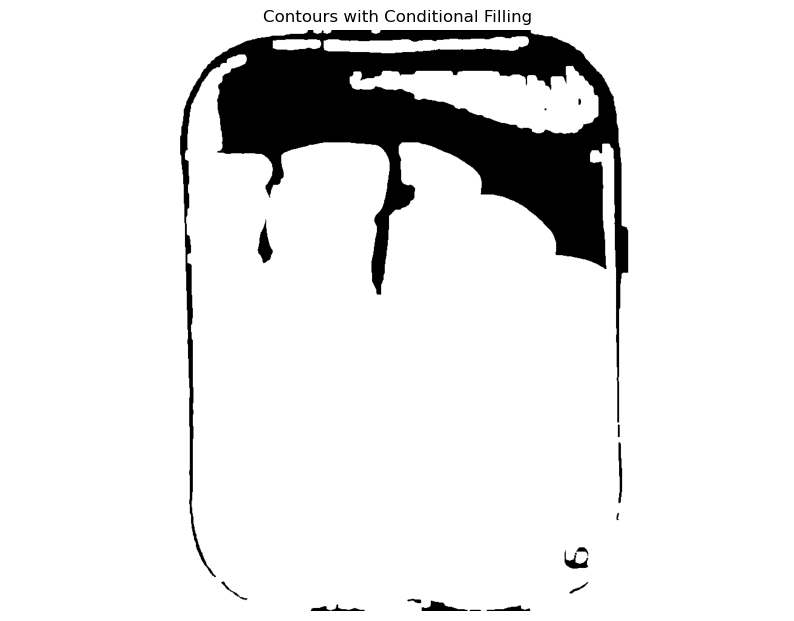

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖像
image_path = "../data/pics/try/caries-0.6741573-260-760_1_2022052768.png"
image = cv2.imread(image_path)

# 轉換為灰度圖像
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 使用Canny邊緣檢測找到邊緣
edges = cv2.Canny(gray_image, 100, 200)

# 找到輪廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 建立一個用於顯示的空白圖像
contour_display_image = image.copy()

# 遍歷所有輪廓並根據條件進行填充
for contour in contours:
    area = cv2.contourArea(contour)
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], -1, 255, -1)  # 建立掩膜
    mean_val = cv2.mean(gray_image, mask=mask)[0]  # 計算該區域的平均灰度值
    
    if area < 1000 and mean_val > 128:  # 白色（平均值接近255）
        print(f"填充面積小於1000的白色區域為黑色，面積為: {area}")
        cv2.drawContours(contour_display_image, [contour], -1, (0, 0, 0), thickness=cv2.FILLED)  # 將面積小於1000的白色區域填滿黑色
    elif area < 600 and mean_val <= 128:  # 黑色（平均值接近0）
        print(f"填充面積小於600的黑色區域為白色，面積為: {area}")
        cv2.drawContours(contour_display_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)  # 將面積小於600的黑色區域填滿白色

# 顯示結果
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_display_image, cv2.COLOR_BGR2RGB))
plt.title('Contours with Conditional Filling')
plt.axis('off')
plt.show()
